# Exercise 7 - Monte Carlo Localization

In this assignment you need to implement a particle filter algorithm for localizing a robot in a given map. 
The data for this exercise is recorded on a differential drive robot equipped with a 2D laser scanner that moves in the following environment:

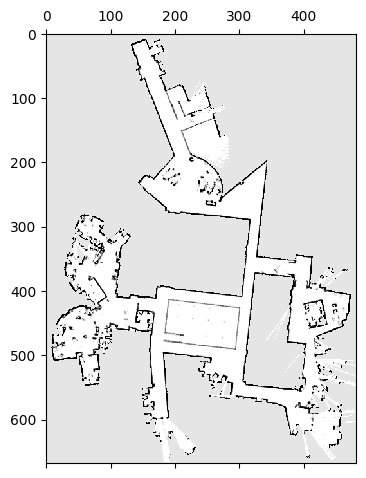

In [11]:
import pickle
import matplotlib.pyplot as plt

data = pickle.load(open("dataset_mit_csail.p", "rb"))

plt.matshow(data['img_map'], cmap="gray")
plt.show()

The following data is provided in `data`:

- *img_map* is the image of the environment where the robot must localize
- *likelihood_map* is the likelihood map defined over the environment and used for computing the weights of the particles
- *odom* is the noisy odometry readings observed by the robot during navigation in the form: $\delta_{rot1}, \delta_{trans}, \delta_{rot2}$
- *gt_odom* is the ground truth odometry, you may want to use it for checking your results
- *z* are the laser range measurements (37 beams $\rho_i, \phi_i$) obtained by the robot during navigation, where $\rho_i$ is the range and $\theta_i$ the corresponding firing angle defined wrt the robot orientation

You can access the `data` as follows:

In [2]:
import pickle

data = pickle.load(open("dataset_mit_csail.p", "rb"))

for i in range(5):
    print(f"Odom[{i}]: {data['odom'][i]}")

Odom[0]: [ 0.04399721 -0.0434027   0.01748448]
Odom[1]: [0.39177679 0.35201752 0.63884236]
Odom[2]: [0.37403659 0.35226703 0.59041166]
Odom[3]: [0.28813319 0.54580278 0.37421297]
Odom[4]: [0.24818284 0.61360259 0.20928147]


Odom at step 25 is:  [ 0.11378333  0.50803543 -0.18586595]
True odom at step 25 is:  [ 0.08237367  0.53204367 -0.23049267]
Angles at step 10 is:  [-1.570796e+00 -1.483526e+00 -1.396256e+00 -1.308986e+00 -1.221716e+00
 -1.134446e+00 -1.047176e+00 -9.599060e-01 -8.726360e-01 -7.853660e-01
 -6.980960e-01 -6.108260e-01 -5.235560e-01 -4.362860e-01 -3.490160e-01
 -2.617460e-01 -1.744760e-01 -8.720600e-02  6.400000e-05  8.733400e-02
  1.746040e-01  2.618740e-01  3.491440e-01  4.364140e-01  5.236840e-01
  6.109540e-01  6.982240e-01  7.854940e-01  8.727640e-01  9.600340e-01
  1.047304e+00  1.134574e+00  1.221844e+00  1.309114e+00  1.396384e+00
  1.483654e+00  1.570924e+00]
Ranges at step 10 is:  [ 3.    2.99  1.33  1.23  1.16  1.14  1.34  1.43  1.4   2.94  3.    3.07
  3.2   3.22  3.59  3.7   3.86  2.75 81.91  1.65  1.68  1.81 81.91 81.91
  4.73  4.76  3.76  4.18  2.3   2.31  5.7   2.33  2.41  4.23  4.09  4.02
 81.91]


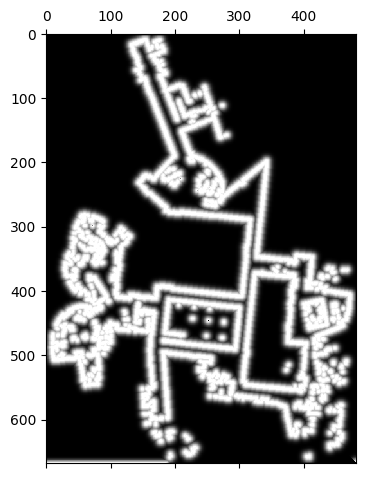

In [5]:
import pickle

data = pickle.load(open("dataset_mit_csail.p", "rb"))

# get odometry reading at timestep 25
odom_25 = data['odom'][25]
print("Odom at step 25 is: ", odom_25)

# get ground truth odometry reading at timestep 25
odom_gt_25 = data['gt_odom'][25]
print("True odom at step 25 is: ", odom_gt_25)

# get observed scan at timestep 10
z_10 = data['z'][10]
print("Angles at step 10 is: ", z_10[0,:])
print("Ranges at step 10 is: ", z_10[1,:])

plt.matshow(data['likelihood_map'], cmap="gray")
plt.show()

## 7.1 Motion update [2.0]

The `sample_motion_model_odometry` function defines the sampling-based odometry motion model. 

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$
- the odometry readings $u_t = [\delta_{rot1}, \delta_{trans}, \delta_{rot2}]$ 
- the noise parameters $\mathbf{\alpha} = [0.1, 0.1, 0.1, 0.1]$

The output is a new (sampled) pose predicted by the motion model.

Implement the `sample_motion_model_odometry` function and verify that it is correct for some test input. 

You **can** re-use the your implementation from Exercise 3. 

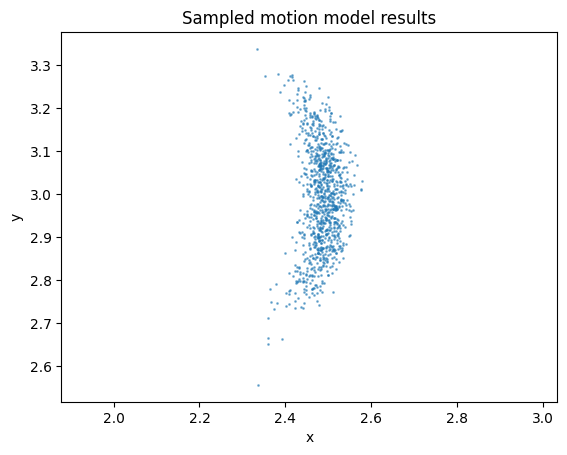

In [16]:
import ex7 as ex
import numpy as np
import matplotlib.pyplot as plt

prev_pose = [2.0, 3.0, 0.0]
odom = [[0.0, 0.0, 0.0], [0.5, 0.0, np.pi/2]]
alpha = [1.0, 1.0, 0.01, 0.01]

samples = [ex.sample_motion_model_odometry(prev_pose, odom, alpha) for _ in range(1000)]

samples = np.array(samples)

plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sampled motion model results")
plt.axis("equal")
plt.show()

## 7.2 Compute weights [6.0]

The `compute_weights` function is responsible for computing the importance weight for each particle according to the observation model, i.e.,

$$w_{i,t} = \eta\,p(z_{t}|x_{i,t}).$$

The motion model is obtained by querying the likelihood map defined over the environment in the endpoints of the laser scan ranges.

The available `ranges2cells` function computes the endpoints of raw scans $(\rho, \phi)$ into map coordinates.

Implement the `compute_weights` function and verify that it is correct for some test input. 

Computed weights: [1.09604371e-10 1.88832392e-07 2.52716907e-01 2.50968522e-10
 4.73512296e-08 9.13690949e-09 3.74577992e-10 1.63042754e-06
 4.95894149e-05 2.43415514e-01 4.87775380e-02 2.72763472e-02
 7.84483341e-04 3.51990791e-02 3.26965616e-02 1.19109641e-10
 1.14862190e-07 3.52431055e-02 1.08207043e-06 2.40733413e-03
 1.02654701e-05 6.37536803e-05 1.28030680e-01 1.21027757e-01
 9.82626578e-08 4.87901007e-05 5.76768010e-03 1.11120329e-10
 7.45444268e-09 1.41037093e-06 2.61336581e-08 4.34355276e-05
 3.71459609e-03 1.04700618e-02 4.36169638e-07 1.36457615e-10
 5.79551427e-08 6.93456282e-07 4.33232896e-04 1.05913277e-05
 1.09946666e-10 2.52150374e-04 5.50106710e-05 7.58384201e-03
 4.39156136e-02 2.55177441e-07 1.09368449e-10 1.31463409e-10
 1.67297252e-10 2.04278374e-08]
Sum of weights (should be 1): 1.0


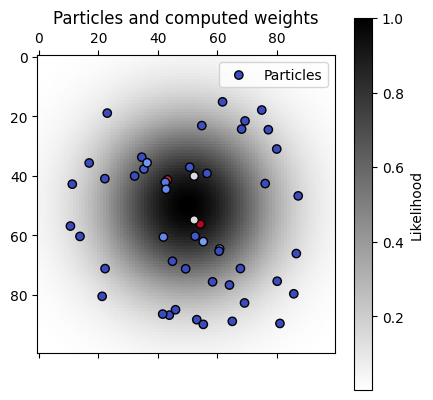

In [8]:
import ex7 as ex
import numpy as np
import matplotlib.pyplot as plt

# Create a synthetic likelihood map (higher likelihood in the center)
likelihood_map = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        likelihood_map[i, j] = np.exp(-((i - 50)**2 + (j - 50)**2) / (2 * 20**2))  # Gaussian distribution

# Create a simple grid map
gridmap = np.ones((100, 100))

# Map resolution
map_res = 1  # 1 meter per grid cell

# Generate test particles
num_particles = 50
particles = np.zeros((num_particles, 4))
particles[:, 0] = np.random.uniform(10, 90, num_particles)  # X positions
particles[:, 1] = np.random.uniform(10, 90, num_particles)  # Y positions
particles[:, 2] = np.random.uniform(-np.pi, np.pi, num_particles)  # Orientations
particles[:, 3] = 1.0  # Initial weights

# Generate a synthetic observation (ranges and angles)
angles = np.linspace(-np.pi / 2, np.pi / 2, 10)  # 10 beams spanning -90° to 90°
ranges = np.random.uniform(5, 15, 10)  # Random ranges between 5m and 15m
z_obs = np.vstack((angles, ranges))  # Shape (2, 10)

# Compute weights using the function
weights = ex.compute_weights(particles, z_obs, gridmap, likelihood_map, map_res)

# Print results
print("Computed weights:", weights)
print("Sum of weights (should be 1):", np.sum(weights))

# Plot particles and likelihood map
plt.matshow(likelihood_map, cmap="binary")
plt.colorbar(label="Likelihood")
plt.scatter(particles[:, 0], particles[:, 1], c=weights, cmap="coolwarm", edgecolors="black", label="Particles")
plt.legend()
plt.title("Particles and computed weights")
plt.show()

## 7.3 Resampling [6.0]

The `resample` function is responsible for re-sampling particles according to their weight (the higher the more likely to be samples) and, thus, “kills” the particles with low weight.

Implement the `resample` function (low-variance resampling) and verify that it is correct for some test input. 

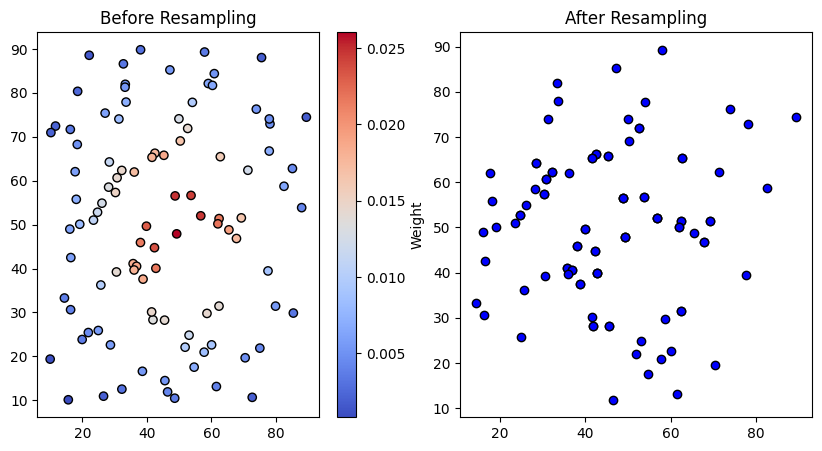

In [1]:
import ex7 as ex
import numpy as np
import matplotlib.pyplot as plt

# Generate test particles
num_particles = 100
particles = np.zeros((num_particles, 4))
particles[:, 0] = np.random.uniform(10, 90, num_particles)  # X positions
particles[:, 1] = np.random.uniform(10, 90, num_particles)  # Y positions
particles[:, 2] = np.random.uniform(-np.pi, np.pi, num_particles)  # Orientations
particles[:, 3] = 1.0  # Initial weights

# Assign artificial weights (higher for particles near the center)
weights = np.exp(-((particles[:, 0] - 50)**2 + (particles[:, 1] - 50)**2) / (2 * 20**2))
weights /= np.sum(weights)  # Normalize

# Resample particles
resampled_particles = ex.resample(particles, weights)

# Plot before and after resampling
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(particles[:, 0], particles[:, 1], c=weights, cmap="coolwarm", edgecolors="black")
plt.title("Before Resampling")
plt.colorbar(label="Weight")

plt.subplot(1, 2, 2)
plt.scatter(resampled_particles[:, 0], resampled_particles[:, 1], c="blue", edgecolors="black")
plt.title("After Resampling")

plt.show()

## 7.4 Localization [6.0]

Once you complete all the above functions, implement the main procedure of Monte Carlo localization `mc_localization` which recursively estimate the position of the robot using the odometry data and the laser scans.

Consider 5000 particles that are intialized uniformly over the environment. 

The map resolution is 0.1 and each particle is a $(x,y,\theta)$ pose.

Plot the belief about the position of the robot after the sequence of odometry readings and laser scans provided in `data` by using the `plot_particles` function.

In [ ]:
import ex7 as ex
import pickle

data = pickle.load(open("dataset_mit_csail.p", "rb"))

# Run Monte Carlo Localization
num_particles = 5000
map_res = 0.1
noise = [0.1, 0.1, 0.1, 0.1]

particles = ex.init_uniform(num_particles, data['img_map'], map_res)
particles = ex.mc_localization(data['odom'], data['z'], num_particles, particles, noise, data['img_map'], data['likelihood_map'], map_res, data['img_map'])

# Plot final particle distribution
ex.plot_particles(particles, data['img_map'], map_res)